In [2]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes

Populating the interactive namespace from numpy and matplotlib


In [3]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [242]:
oldinp = "../indata/DFDpleasework2.inp"
fn = "../indata/DFD_crap"
Mi = 10
Nt = 1
case =6



Nstar = 0
Np  =7
Nn = 8
L = 10
T = 40
a = 100
D = .1
Ls = [L]*Np
Ns = [int(l) for l in Ls]
#jt = [1,3,1,3,1,3,1,1]#for DFDpleasework.inp
jt = [1,2,2,2,2,2,2,1]#for DFDpleasework2.inp
bt = [0,1,1,1,1,1,1,1]
bv = [0,1,1,1,1,1,1,1]
r =  [0,1,1,1,1,1,1,-1]
h0s = [0]*Np
q0s = [0]*Np
dx = [L/Ns[0]]
Mrs = [0.001]*Np
if(case==0):
    elevs = [10,9,8,7, 6,7.5,9,10]
elif(case==1):
    elevs =[10,11,9,7,6,8,11,10]
elif(case==2):
    elevs =[10,9,8,8,6,7,7,10]
elif(case==3):
    elevs =[10,8,9,8,6,7,8,10]
elif(case==4):
    elevs =[10,8,9,6,6,8,9,10]
elif(case==5):
    elevs =[10,10,9,9,6,9,10,10]
elif(case==6):
    #(e0,e1,e2,e3,e4)=[  8.668513  ,   7.33997448,   6.46810775,  10.83639369,  11.30210679]
    (e0,e1,e2,e3,e4)=[ 8.85165718,  7.39998551,  6.62564389,  9.59220709,  9.6376309]
    elevs = [10,e0,e1,e2,6,e3,e4,10]
    
#elevs =[10,11,10,10,6,10,10,10]
#elevs =[10, 9,8,5,6,4,4,3]
#elevs = [10,9,8,7,6,5,4,3]
#elevs = [10,9.5,9,8.5,8,7,6,3]
#elevs = [10, 11, 9, 8, 5, 6, 4,3]
Ds = [D]*Np
M = max(int(T*a/(max(dx)*.8))*5,1)
Ls = [L]*Np
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
dt = T/float(M)
Hs =np.ndarray((Np,M/Mi*Nt))
Us = np.ndarray((Np,M/Mi*Nt))
Qs = np.ndarray((Np,M/Mi*Nt))

new files are ../indata/DFD_crap.inp and ../indata/DFD_crap.config


In [243]:
n1 = PyNetwork(fi,fc,1)
Q00 = 0.0087*np.ones(M+1)
j = 0
p0 = PyPipe_ps(n1.Ns[j],n1.Ds[j], n1.Ls[j],M,a)
Ain = p0.AofH(10,False)
Q00 = Ain*np.ones(M+1)
n1.setbVal(0,Q00)
A0 = Ain*np.ones(Ns[0])
Q0 = np.zeros(Ns[0])
n1.setIC(0,A0,Q0)
print Ain
#n1.showCurrentData()

0.00793018096379


0
[0.07930180963787685, 0.5567295873150828]


/Users/lieba/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Users/lieba/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


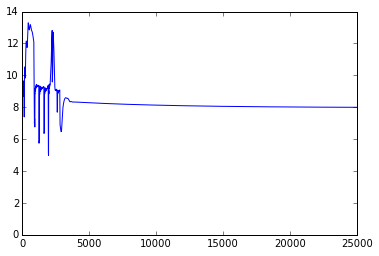

In [244]:
Vs = [n1.getTotalVolume()]
for m in range(Nt):
    n1.runForwardProblem(dt)
    for j in range(Np):
        N = n1.Ns[j]
        p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        qh = n1.qhist(j)
        Htemp = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
        Utemp = [qh[idx_t(1,Nstar,n,n1.Ns[j])]/qh[idx_t(0,Nstar,n,n1.Ns[j])] for n in range(1,M+1,Mi)]
        Us[j,m*(M/Mi):(M/Mi)*(m+1)] = Utemp
        Hs[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp
    Vs.append(n1.getTotalVolume()) 
    print m
    print Vs
    n1.reset()
dH = [n1.getAveGradH(i) for i in range(M+1)]
plot(dH)

(0, 11)

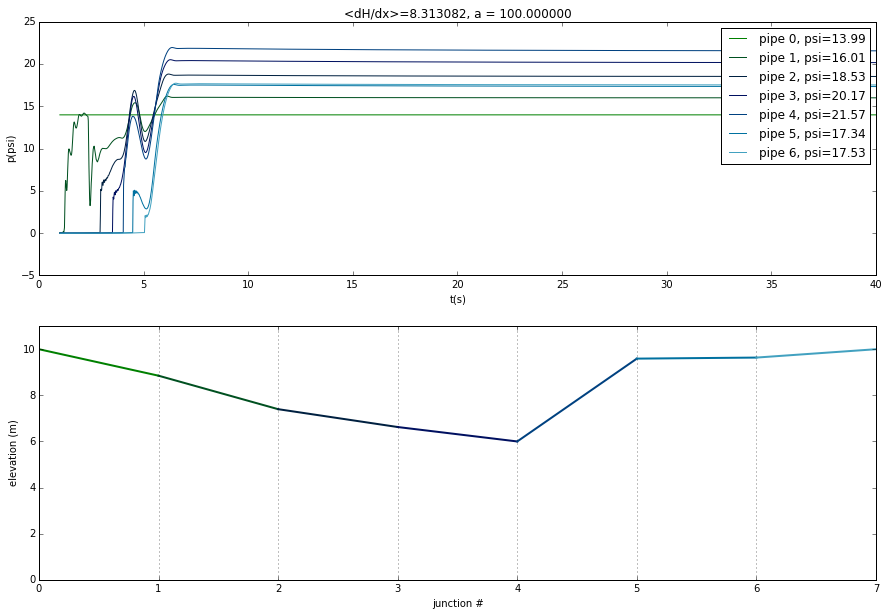

In [245]:
m2psi = 1.42
from matplotlib import cm
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
fig,ax = plt.subplots(nrows=2, figsize=(15,10))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
Ttot= T*Nt
t=linspace(1,Ttot,len(Hs[0]))
for j in range(0,Np):
    ax[0].plot(t,Hs[j]*m2psi, color = scalarMap.to_rgba(j), label = "pipe %d, psi=%.2f"%(j,Hs[j][-1]*m2psi))
legend(ncol=3, loc = 'lower right')
ylabel('p (psi)')
xlabel('t (s)')
ax[0].legend(loc ='upper right')
ax[0].set_title('<dH/dx>=%f, a = %f'%(mean(dH),a))
#ax[0].set_ylim(0,35)
ax[0].set_ylabel('p(psi)')
ax[0].set_xlabel('t(s)')
Ltot = 0
E = elevs[0]
xs = []
#fig,ax = plt.subplots(figsize=(15,5))
for k in range(Nn-1):
    L = n1.Ls[k]
    x = linspace(0,L)
    cval = scalarMap.to_rgba(k)
    ax[1].plot(x+Ltot,x*(elevs[k+1]-elevs[k])/L+E,color = cval, lw = 2)
    xs.append(Ltot)
    Ltot+=L
    E = elevs[k+1]
xs.append(Ltot)
ax[1].set_xticks(xs);
ax[1].xaxis.grid(True)
ax[1].set_xticklabels(arange(0,Nn+1));
ylabel('elevation (m)')
xlabel('junction #')
ax[1].set_ylim(0,11)
#ax[0].set_xlim(9,10)
#savefig('/Users/lieba/Desktop/elevation_profilecase%d.png'%case)

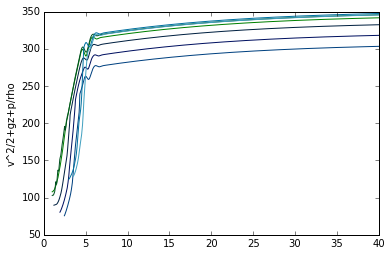

In [235]:
t=linspace(1,Ttot,len(Hs[0]))
for j in range(0,Np):
    plot(t,[(u**2)/2+9.8*elevs[j] for u in Us[j]]+Hs[j], color = scalarMap.to_rgba(j), label = "pipe %d"%(j))
#legend(ncol=3, loc = 'lower right')
#ylim(0,350)
ylabel('v^2/2+gz+p/rho')

In [236]:
B = [(Us[j][-1]**2)/2+9.8*elevs[j]+Hs[j][-1] for j in range(Np)]
print B

[341.65366631683116, 345.69373655114981, 332.35183649012868, 318.0676642566761, 303.29559395389452, 347.42673556559424, 345.51593389983589]


In [237]:
m32gal=264.172052
print "a = %f m/s" %a
print "inflow volume = %.2f gallons"%((Vs[-1]-Vs[0])*m32gal)

a = 100.000000 m/s
inflow volume = 125.47 gallons


In [238]:
Af = []
Qf = []
for k in range(Np):
    q = n1.q(k)
    Af.append(np.array(q[0:Ns[k]]))
    Qf.append(np.array(q[ Ns[k]:]))

new files are ../indata/DFD_crap.inp and ../indata/DFD_crap.config


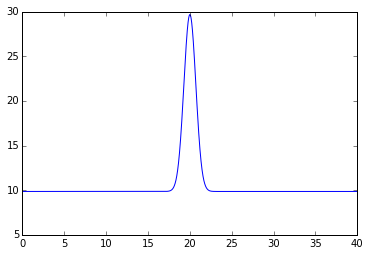

In [263]:
bt = [0,1,1,1,1,1,1,1]
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
n2 = PyNetwork(fi,fc,1)
eps = 0.1
t = linspace(0,T,M+1)
Q00 = Ain*(np.ones(M+1)+eps*exp(-(t-T/2)**2)/5)
p0 = PyPipe_ps(n1.Ns[j],n1.Ds[j], n1.Ls[j],M,a)
Ain = p0.AofH(10,False)
Q00 = Q00*np.ones(M+1)
n2.setbVal(0,Q00)
A0 = Ain*np.ones(Ns[0])
Q0 = np.zeros(Ns[0])
for i in range(Np):
    n2.setIC(i,Af[i],Qf[i])
plot(t,[p0.pbar(Q00[i],False) for i in range(M+1)])
P0 = [p0.pbar(Q00[i],False) for i in range(M+1)]
dP= max(P0)-min(P0)

In [265]:
n2.runForwardProblem(dt)

pipe  dH/dP
0    1.419996
1    1.574542
2    1.641634
3    1.665104
4    1.744444
5    1.815983
6    1.880619


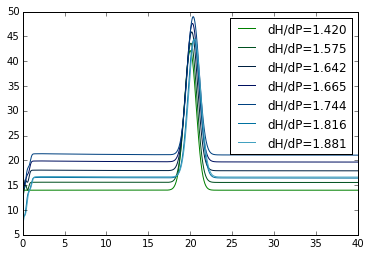

In [267]:
t= linspace(0,T,M/Mi)
print "pipe  dH/dP"
for i in range(Np):
    qh = n2.qhist(i)
    Htemp = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False)*m2psi for n in range(1,M+1,Mi)]
    plot(t,Htemp, color = scalarMap.to_rgba(i), label ="dH/dP=%.3f"%((max(Htemp)-min(Htemp))/dP))
    print "%d    %f"%(i,(max(Htemp)-min(Htemp))/dP)
legend()

In [ ]:

pipe  dH/dP
0    1.419996
1    1.417574
2    1.414482
3    1.412778
4    1.408060
5    1.410061
6    1.409670

In [246]:
efs = [(8.99667311, 7.55460495, 6.56988317, 8.02535513, 9.44829998),
       (8.99667311, 7.55460495, 6.56988317, 8.02535513, 9.44829998),
       (8.87961415, 7.44107828, 6.69715121, 6.64909921, 9.46860068),
       (9.08827789,7.64038788,6.79131568,7.48889938,9.45728186),
       (9.10379808,7.67604673,6.71284203,9.80499452,9.72854505)]

In [247]:
e0s = [(9,5,7,11,9),
      (9,5,7,11,9),
       (8,9,6,5,8),
       (9,8,7,7,8.5),
       (10,7,8,11,8.5)]

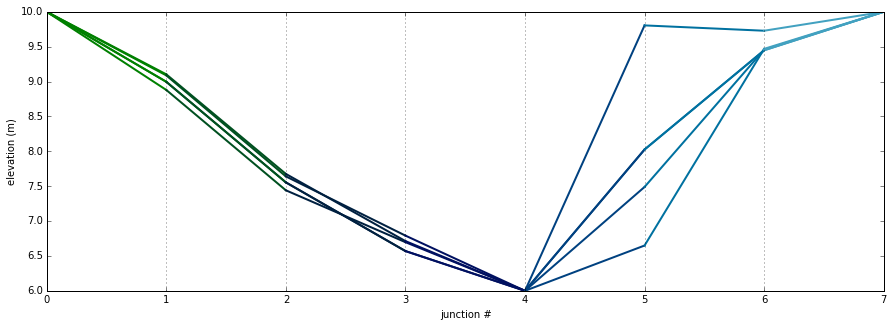

In [260]:


fig,ax = plt.subplots(nrows=1, figsize=(15,5))
for j in range(5):
    Ltot=0
    for k in range(Nn-1):
        L = n1.Ls[k]
        x = linspace(0,L)
        cval = scalarMap.to_rgba(k)
        (e0,e1,e2,e3,e4) = efs[j]
        elevs = [10,e0,e1,e2,6,e3,e4,10]
        ax.plot(x+Ltot,x*(elevs[k+1]-elevs[k])/L+E,color = cval, lw = 2)
        xs.append(Ltot)
        Ltot+=L
        E = elevs[k+1]
#xs.append(Ltot)
#ax.set_xticks(xs);
ax.xaxis.grid(True)
ax.set_xticklabels(arange(0,Nn+1));
ylabel('elevation (m)')
xlabel('junction #')